In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as npa
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans
import os 

In [10]:
print(os.getcwd())

/home/abigail/Documents/Sephora_Regression/Notebooks


In [15]:

df = pd.read_csv('../Data/product_info.csv')

## Data Preparation 

The steps of the data preparations process are outlined below. 

<u>Detection and Treatment</u>
1. Duplicate observations 
2. Missing values
3. Outliers 

<u>Data Wrangling</u>
1. Label Encode the categorical variables 
2. Group dependent variable(rating) using Kmeans clustering 

#### Cleaning 

In [2]:
# Find Duplicates 
df.duplicated().value_counts()
# No duplicates found = No Treatment 

False    8494
Name: count, dtype: int64

In [3]:
# Find Missing Values 
df.isnull().sum()

product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64

In [4]:
# Drop columns with too many missing values  
df = df.drop(['variation_type','variation_value','variation_desc','ingredients','value_price_usd','sale_price_usd','highlights','tertiary_category','child_max_price','child_min_price'], axis=1)

In [5]:
# Remove all rows with missing values in rating column: This should also remove all missing values in the review column
df = df.dropna(subset = ['rating'])

In [6]:
# Impute secondary_category with mode 
# Not imputing missing values for size: During encoding missing value will be represented by 0 
df['secondary_category'] = df['secondary_category'].fillna(df['secondary_category'].mode()[0])

In [7]:
# Not imputing missing values for size: During encoding missing value will be represented by 0 
df['size'].fillna(0,inplace=True)

In [8]:
df.isnull().sum()

product_id            0
product_name          0
brand_id              0
brand_name            0
loves_count           0
rating                0
reviews               0
size                  0
price_usd             0
limited_edition       0
new                   0
online_only           0
out_of_stock          0
sephora_exclusive     0
primary_category      0
secondary_category    0
child_count           0
dtype: int64

In [9]:
df.shape

(8216, 17)

Stats with Outliers:  count    8216.000000
mean       51.228229
std        53.406409
min         3.000000
25%        25.000000
50%        35.000000
75%        58.000000
max      1900.000000
Name: price_usd, dtype: float64
35.0


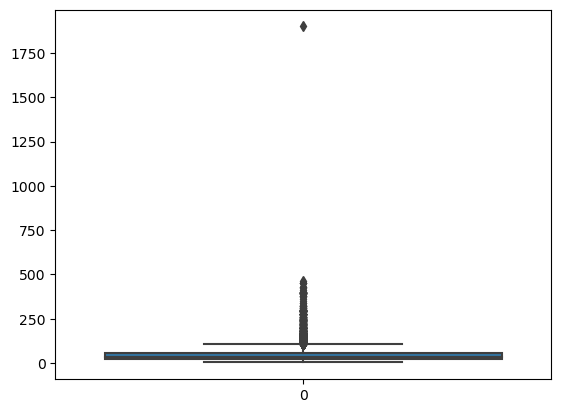

In [11]:
# Find outliers with boxplot 
sns.boxplot(df['price_usd'])
print('Stats with Outliers: ',df['price_usd'].describe())
print(df['price_usd'].median())

# Dont need z_score: remove only max outlier



Stats with Imputed Outliers:  count    8216.000000
mean       51.001233
std        49.357493
min         3.000000
25%        25.000000
50%        35.000000
75%        58.000000
max       465.000000
Name: price_usd, dtype: float64
35.0


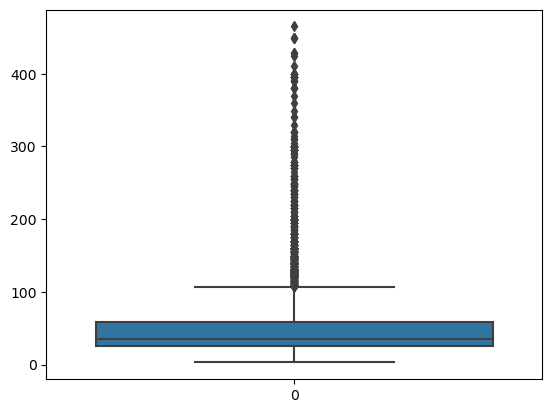

In [12]:
# Remove all above 700
df['price_usd'] = np.where(df['price_usd'] > 700,np.nan,df['price_usd'])
df['price_usd'].fillna(df['price_usd'].median(), inplace = True)
sns.boxplot(df['price_usd'])

#Verify after treatment 
print('Stats with Imputed Outliers: ',df['price_usd'].describe())
print(df['price_usd'].median())


Stats with Outliers:  count    8216.000000
mean        1.678797
std         5.458718
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       105.000000
Name: child_count, dtype: float64
0.0


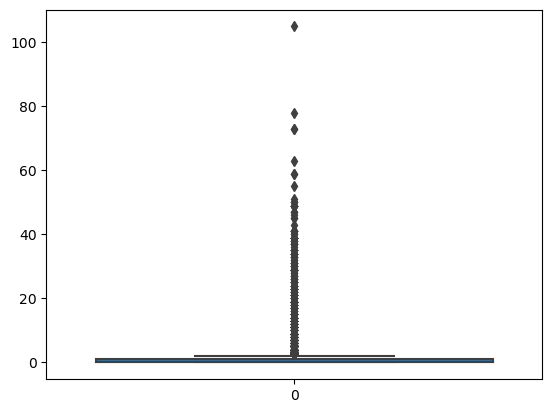

In [13]:
#Find z_score : new column will be deleted later 
df['z_child'] = stats.zscore(df['child_count'])

#Visualize before treatment 
sns.boxplot(df['child_count'])
print('Stats with Outliers: ',df['child_count'].describe())
print(df['child_count'].median())

Stats with Imputed Outliers:  count    8216.000000
mean        0.948759
std         2.293111
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        18.000000
Name: child_count, dtype: float64
0.0


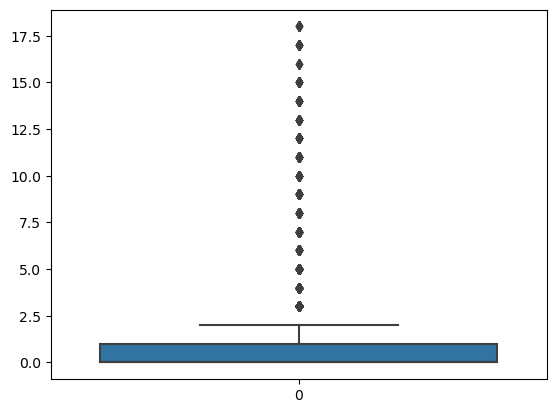

In [14]:
#Impute with median where z_score > 3
df['child_count'] = np.where(df['z_child']>3,np.nan,df['child_count'])
df['child_count'].fillna(df['child_count'].median(), inplace = True)

#Verify after Imputation 
sns.boxplot(df['child_count'])
print('Stats with Imputed Outliers: ',df['child_count'].describe())
print(df['child_count'].median())


#### Wrangling (Encoding)

In [16]:
# Label encode primary_category 
encoder = LabelEncoder()
df['primary_category_label'] = encoder.fit_transform(df['primary_category'])

In [17]:
# Label encode secondary_category 

df['secondary_category_label'] = encoder.fit_transform(df['secondary_category'])

In [18]:
# Change labels for size 
# no size = 0 , 0.5 oz/ 15 mL = 1, 1 oz/ 30 mL = 2, 1.7 oz/ 50 mL = 3, 3.4 oz/ 100 mL = 4 , other = 5 
df['size'] = df['size']
dict_over = {'size':{"0.5 oz/ 15 mL":1,"1 oz/ 30 mL": 2,"1.7 oz/ 50 mL":3,"3.4 oz/ 100 mL":4}}
df.replace(dict_over, inplace = True)
df['size']

for i in df['size']:
    if i not in (0,1,2,3,4):
        df['size'] == df['size'].replace(i,5, inplace= True)
print(df['size'])

0       0
1       4
2       4
3       4
4       4
       ..
8487    0
8488    0
8489    0
8490    5
8491    0
Name: size, Length: 8216, dtype: int64


Text(0.5, 1.0, 'Product Rating Distribution')

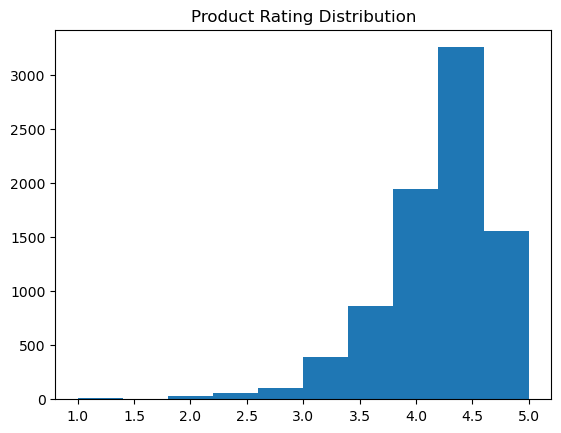

In [20]:
plt.hist(df['rating'])
plt.title('Product Rating Distribution')

In [21]:
# Use Kmeans clustering to identify groups of ratings
# 5 clusters for ratings 1-5

X = df[['rating']].values.reshape(-1,1) #reshape single-column bc kmeans expects 2D array

kmeans = KMeans(n_clusters=5,random_state=0)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

/home/abigail/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
kmeans_df = pd.DataFrame(centroids)
kmeans_df

,0
0,4.721064
1,3.348646
2,4.344363
3,2.229989
4,3.938616


In [23]:
#Change labels
kmeans.labels_[kmeans.labels_ == 0] = 10
kmeans.labels_[kmeans.labels_ == 1] = 7
kmeans.labels_[kmeans.labels_ == 2] = 9
kmeans.labels_[kmeans.labels_ == 3] = 6
kmeans.labels_[kmeans.labels_ == 4] = 8


In [24]:
#Change labels to represent 1-5 stars
kmeans.labels_[kmeans.labels_ == 10] = 5
kmeans.labels_[kmeans.labels_ == 9] = 4
kmeans.labels_[kmeans.labels_ == 8] = 3
kmeans.labels_[kmeans.labels_ == 7] = 2
kmeans.labels_[kmeans.labels_ == 6] = 1

In [25]:
df['rating_clusters'] = labels
df[['rating','rating_clusters']]

,rating,rating_clusters
0,3.6364,2
1,4.1538,4
2,4.2500,4
3,4.4762,4
4,3.2308,2
...,...,...
8487,3.5000,2
8488,5.0000,5
8489,4.4286,4
8490,4.6367,5


#### Remove Columns 

In [ ]:
df = df.drop(['product_id','brand_name','loves_count','product_name','z_child'], axis=1)

In [ ]:
print(df)

####

In [ ]:
#Export 
path = '/home/abigail/Documents/Sephora_Regression/Data'
df.to_csv(path,'cleaned_data.csv')